In [1]:
    import warnings  # Import the warnings module

    # Ignore all warning messages to keep the output clean
    warnings.filterwarnings('ignore')

In [2]:
# 1. Define the directory paths for the training and testing datasets
train_dir = "/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/train"
test_dir = "/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test" 

# Print directory paths to confirm
print(f"Training Directory: {train_dir}")
print(f"Testing Directory: {test_dir}")

Training Directory: /kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/train
Testing Directory: /kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test


In [3]:
# 2. Import ImageDataGenerator for data augmentation and preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator instance for the training set with specified transformations
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Rescale pixel values from [0, 255] to [0, 1] (normalization)
    shear_range=0.2,        # Apply random shearing transformations
    zoom_range=0.2,         # Apply random zoom transformations
    horizontal_flip=True    # Randomly flip the images horizontally
)

In [4]:
# 3. Create an ImageDataGenerator instance for the validation set
validation_datagen = ImageDataGenerator(
    rescale=1./255  # Rescale pixel values for normalization (from [0, 255] to [0, 1])
)

In [5]:
# 4. Create a data generator for the training set using the ImageDataGenerator instance
train_generator = train_datagen.flow_from_directory(
    train_dir,               # Path to the training data directory
    target_size=(224, 224),  # Resize all images to 224x224 pixels
    batch_size=1,           # Number of images to be yielded from the generator per batch
    class_mode='binary'      # Specify binary classification (e.g., COVID-19 vs. Normal)
)

Found 148 images belonging to 2 classes.


In [6]:
# 5. Create a data generator for the testing/validation set using the ImageDataGenerator instance
test_generator = validation_datagen.flow_from_directory(
    test_dir,                # Path to the testing/validation data directory
    target_size=(224, 224),  # Resize all images to 224x224 pixels
    batch_size=1,            # Number of images to be yielded from the generator per batch
    class_mode='binary',     # Specify binary classification (e.g., COVID-19 vs. Normal)
    shuffle=False            # Disable shuffling
)

Found 40 images belonging to 2 classes.


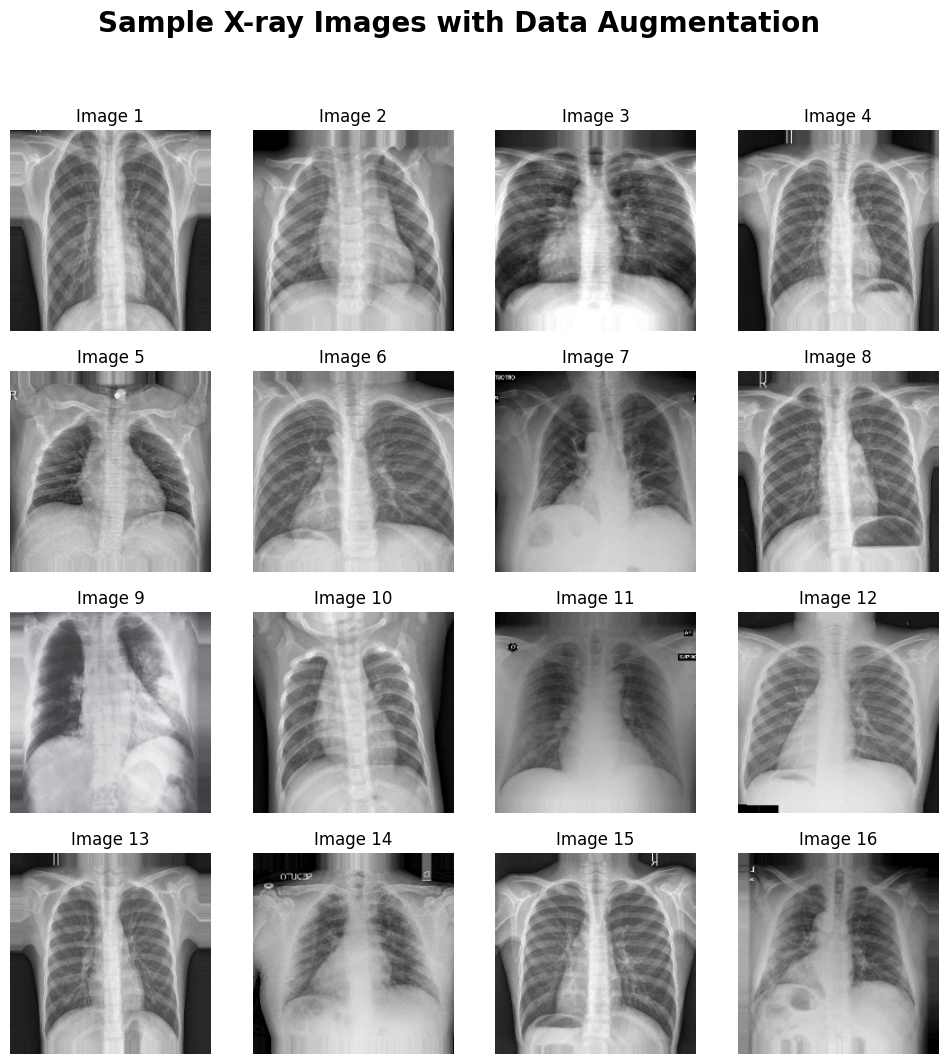

In [7]:
import numpy as np  # NumPy library: Supports numerical operations and works with arrays.
import matplotlib.pyplot as plt  # Matplotlib library: Used for creating graphs and visualizations.

# Function to display augmented images with numbering
def display_augmented_images(generator, num_images=16):
    plt.figure(figsize=(12, 12))  # Create a new display window with size 12x12 inches.
    
    for i in range(num_images):
        img, _ = next(generator)  # Retrieve a new image from the generator (ignore labels).
        plt.subplot(4, 4, i + 1)  # Create a grid of 4 rows and 4 columns to display images.
        plt.imshow(img[0])  # Display the first image from the batch.
        plt.axis('off')  # Hide the axes.
        
        # Add numbering to each image
        plt.title(f'Image {i + 1}', fontsize=12)  # Add a title for each image.

    plt.suptitle("Sample X-ray Images with Data Augmentation",
                 fontsize=20,
                 fontweight='bold')  # Add a main title for the display.
    
    # Save the figure with high resolution
    plt.savefig('augmented_images_with_numbers.png',
                dpi=300,
                bbox_inches='tight')  # Save the figure as a PNG file with high resolution.
    plt.show()  # Display the figure in a window.

# Display 16 sample images with numbering
display_augmented_images(train_generator, num_images=16)  # Display 16 images with numbering.

---

In [8]:
from tensorflow.keras import models
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D

# Step 1: Define the input layer
inputs = Input(shape=(224, 224, 3))  # Specify the input shape

# Step 2: Apply the layers step-by-step
x = Conv2D(32, (3, 3), activation='relu')(inputs)  # First Conv Layer
x = MaxPooling2D((2, 2))(x)  # First Pooling Layer

x = Conv2D(64, (3, 3), activation='relu')(x)  # Second Conv Layer
x = MaxPooling2D((2, 2))(x)  # Second Pooling Layer

x = Conv2D(128, (3, 3), activation='relu')(x)  # Third Conv Layer
x = MaxPooling2D((2, 2))(x)  # Third Pooling Layer

x = Conv2D(128, (3, 3), activation='relu')(x)  # Fourth Conv Layer
x = MaxPooling2D((2, 2))(x)  # Fourth Pooling Layer

# Step 3: Add Global Average Pooling instead of Flatten
x = Flatten()(x)

# Step 4: Add Dense layers for classification
x = Dense(512, activation='relu')(x)  # Fully connected layer with 512 units
x = Dropout(0.5)(x)  # Dropout layer for regularization

# Step 5: Output layer for binary classification
outputs = Dense(1, activation='sigmoid')(x)

# Create and summarize the model using the defined function
#model = create_and_summarize_model(inputs=inputs, outputs=outputs)

In [9]:
model = models.Model(
        inputs=inputs,   # 'inputs': TensorFlow Keras Input object or list of Input objects
        outputs=outputs  # 'outputs': TensorFlow Keras Layer object or list of Layer objects
    )

In [10]:
# Compile the model with the given parameters
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(    # Use Adam optimizer for training
        learning_rate=0.0001),     # Set the learning rate to 0.0001
    loss='binary_crossentropy',    # Use binary cross-entropy loss for binary classification
    metrics=['accuracy']           # Track accuracy during training and testing
)


In [11]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,679,041 (36.92 MB)

 Trainable params: 9,679,041 (36.92 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train the model using the training data generator and validate using the testing data generator
history = model.fit(
    train_generator,         # Training data generator
    epochs=20,                # Number of training epochs (iterations over the dataset)
    validation_data=test_generator  # Testing data generator for validation
    )

Epoch 1/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - accuracy: 0.5402 - loss: 0.6860 - val_accuracy: 1.0000 - val_loss: 0.5211
Epoch 2/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 22s 144ms/step - accuracy: 0.6586 - loss: 0.6302 - val_accuracy: 0.9500 - val_loss: 0.3286
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 23s 150ms/step - accuracy: 0.8337 - loss: 0.4082 - val_accuracy: 0.9500 - val_loss: 0.2176
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 23s 149ms/step - accuracy: 0.7987 - loss: 0.3804 - val_accuracy: 0.9750 - val_loss: 0.1575
Epoch 5/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 40s 143ms/step - accuracy: 0.8922 - loss: 0.3060 - val_accuracy: 0.9500 - val_loss: 0.1063
Epoch 6/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.9004 - loss: 0.2628 - val_accuracy: 0.9500 - val_loss: 0.1630
Epoch 7/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 42s 146ms/step - accuracy: 0.8884 - loss: 0.2887 - val_accuracy: 0.9750 - val_loss: 0.0912
Epoch 8/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.9077 - loss: 0

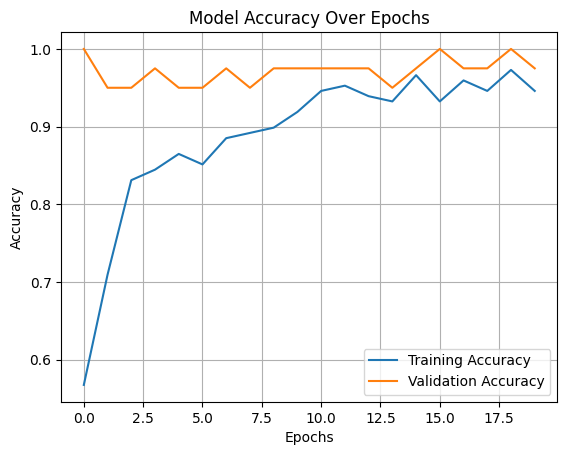

In [13]:
import matplotlib.pyplot as plt

# Plot accuracy during training and validation
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.legend()  # Add legend to the plot
plt.title('Model Accuracy Over Epochs')  # Title of the plot
plt.grid(True)  # Enable grid for better visualization
plt.show()  # Display the plot